# Proyek Analisis Data: Bike Sharing Dataset
- **Nama:** Mayyada Shafira

## Menentukan Pertanyaan Bisnis

**Analisis Data**

Analisis data adalah proses mengolah data agar bisa menghasilkan informasi yang bermanfaat. Prosesnya meliputi mengecek data, membersihkan data, mengubah format data, hingga menarik kesimpulan dari data tersebut.

Peran analisis data dalam mengambil keputusan yaitu bisa dibuat berdasarkan fakta dan pola yang nyata (data-driven decision). Membuatnya membantu mengurangi kesalahan, meningkatkan efisiensi, dan memahami perilaku pengguna dengan lebih objektif.

- Bagaimana pengaruh kondisi cuaca terhadap jumlah rata-rata penyewaan sepeda harian?
- Apakah ada perbedaan pola penyewaan antara hari kerja (workingday) dan hari libur (holiday)?
- Bagaimana perbedaan pola penyewaan sepeda berdasarkan musim dan jenis hari (hari kerja vs hari libur)?

## Import Semua Packages/Library yang Digunakan

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualisasi
sns.set(style='darkgrid')

## Data Wrangling
**Data Cleaning & Data Wrangling**

Pentingnya Data Cleaning dan Data Wrangling karena di dalam data science ada prinsip yaitu “data yang buruk menghasilkan analisis yang buruk.”

Data Cleaning Bertujuan membersihkan data dari kesalahan, data kosong, dan duplikasi agar hasil analisis lebih akurat.

Data Wrangling Mengubah data mentah menjadi format yang lebih mudah dianalisis. Contoh: mengubah tanggal dari teks menjadi format tanggal, atau mengubah kode angka musim menjadi nama musim yang mudah dipahami.

### Gathering Data

In [171]:
# Menghubungkan ke Google Drive
drive.mount('/content/drive')

# Load Dataset
path = '/content/drive/MyDrive/dataaa/dataset/day.csv'
day_df = pd.read_csv(path)

# Menampilkan 5 baris data
day_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**Insight:**
- Dataset memiliki 16 kolom yang mencakup informasi waktu (dteday, season, mnth), kondisi cuaca (weathersit, temp, hum), dan jumlah penyewaan (casual, registered, cnt).

- Kolom cnt (count) adalah variabel target yang merupakan penjumlahan dari pengguna casual dan registered.

- Data menunjukkan variasi jumlah penyewa harian. Sebagai contoh, pada hari pertama terdapat 985 total penyewa, sedangkan pada hari kerja ke-3 meningkat menjadi 1.349 penyewa.

- Variabel cuaca seperti temp, atemp, hum, dan windspeed sudah dalam bentuk ternormalisasi (skala 0 hingga 1), sehingga tidak ada nilai yang sangat ekstrem yang perlu dikoreksi.

### Assessing Data

In [172]:
# Melihat informasi dan bersih tidaknya data
print("~~~Info Dataset~~~~")
day_df.info()

print("\n~~Cek Missing Values~~")
print(day_df.isna().sum())

print("\n~~Cek Duplikasi~~")
print(day_df.duplicated().sum())

~~~Info Dataset~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB

~~Cek Missing Values~~
instant       0
dteday        0
season        0
y

**Insight:**
- Ada yang tipe datanya tidak sesuai yaitu dteday sebagai tipe data object (string). Padahal data tersebut adalah data deret waktu (time-series), kolomnya harus diubah menjadi tipe datetime agar bisa dianalisis trennya secara akurat.
- Kualitas datanya baik karena tidak ditemukan nilai yang hilang (missing values) pada ke-16 kolom yang tersedia. Artinya dataset tidak memerlukan proses pengisian data kosong.
- Jumlah duplikat data adalah 0, yang berarti setiap baris data mewakili catatan unik harian tanpa ada perulangan informasi.
- Data memiliki 731 baris yang sebagian besar kolom bertipe int64 (kategorikal yang diwakili angka) dan float64 (suhu dan kelembapan yang sudah dinormalisasi).

### Cleaning Data

In [173]:
# Mengganti nama kolom agar lebih mudah dibaca
day_df.rename(columns={
    'yr': 'year',
    'mnth': 'month',
    'hum': 'humidity',
    'cnt': 'count'
}, inplace=True)

In [174]:
# Mengubah tipe data tanggal
day_df['dteday'] = pd.to_datetime(day_df['dteday'])

# Mapping angka kategori menjadi label teks agar mudah dibaca saat visualisasi
# Season: 1:Spring, 2:Summer, 3:Fall, 4:Winter
day_df['season_label'] = day_df['season'].map({
    1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'
})

# Weathersit: 1:Clear, 2:Mist, 3:Light Snow/Rain, 4:Heavy Rain
day_df['weather_label'] = day_df['weathersit'].map({
    1: 'Clear/Partly Cloudy',
    2: 'Misty/Cloudy',
    3: 'Light Snow/Rain',
    4: 'Heavy Rain'
})

# Workingday: 0:Holiday/Weekend, 1:Working Day
day_df['workingday_label'] = day_df['workingday'].map({
    0: 'Holiday/Weekend',
    1: 'Working Day'
})

# Cek hasil transformasi
day_df[['dteday', 'season_label', 'weather_label', 'workingday_label']].head()

,dteday,season_label,weather_label,workingday_label
0,2011-01-01,Spring,Misty/Cloudy,Holiday/Weekend
1,2011-01-02,Spring,Misty/Cloudy,Holiday/Weekend
2,2011-01-03,Spring,Clear/Partly Cloudy,Working Day
3,2011-01-04,Spring,Clear/Partly Cloudy,Working Day
4,2011-01-05,Spring,Clear/Partly Cloudy,Working Day


**Insight:**
- Kolom dteday telah berubah dari tipe object menjadi datetime64. Tahap ini penting karena memungkinkan untuk melakukan analisis berdasarkan urutan waktu (tren bulanan atau harian).

- Kolom season dan weathersit yang sebelumnya berupa angka numerik diubah menjadi tipe object. Diubah supaya mempermudah interpretasi saat proses visualisasi.

- Dengan data yang sudah bersih, tidak ada nilai kosong, dan tipe data yang sesuai, dataset siap digunakan untuk tahap eksplorasi (EDA) dan pembuatan model machine learning sederhana.

## Exploratory Data Analysis (EDA) dan Descriptive Analysis
**Perbedaan Descriptive Analysis dengan EDA**

Descriptive Analysis menjawab pertanyaan “Apa yang terjadi?” artinya berfokus merangkum data menggunakan statistik dasar seperti rata-rata, nilai tengah, dan standar deviasi. Contoh: Rata-rata penyewaan sepeda per hari adalah 4.504 unit. Sedangkan,

Exploratory Data Analysis (EDA) menjawab pertanyaan “Mengapa bisa terjadi?” atau “Apa polanya?” EDA digunakan untuk mencari pola, hubungan antar variabel, dan kejanggalan data dengan bantuan grafik dan visualisasi.

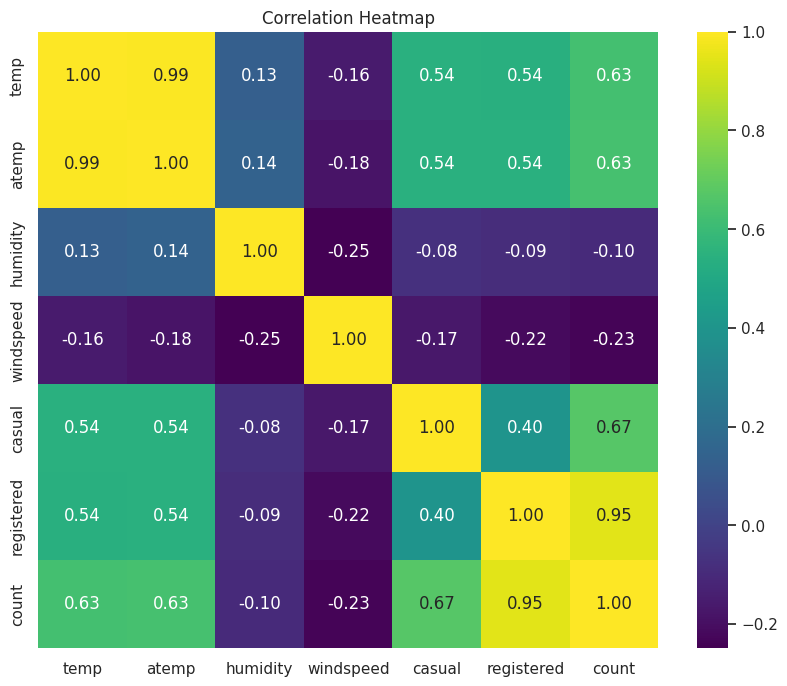

In [175]:
# Heatmap Korelasi
plt.figure(figsize=(10, 8))
numeric_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
corr = day_df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

**Insight**
- Suhu paling berpengaruh pada jumlah sewa. Semakin hangat suhu udara, semakin banyak orang yang menyewa sepeda. Karena itu, cuaca hangat adalah waktu terbaik untuk meningkatkan promosi dan menyiapkan lebih banyak sepeda.

- Suhu asli (temp) dan suhu terasa (atemp) isinya hampir sama, jadi cukup pakai salah satu saja dalam model.

In [176]:
# Statistik deskriptif untuk kolom numerik
print("Statistik Deskriptif (Numerik):")
print(day_df[['temp', 'humidity', 'windspeed', 'count']].describe())

print("\n" + "~"*30 + "\n")

# Distribusi kategori (jumlah hari per kondisi cuaca & musim)
print("Jumlah Data per Kategori Cuaca:")
print(day_df['weather_label'].value_counts())

print("\nJumlah Data per Musim:")
print(day_df['season_label'].value_counts())

Statistik Deskriptif (Numerik):
             temp    humidity   windspeed        count
count  731.000000  731.000000  731.000000   731.000000
mean     0.495385    0.627894    0.190486  4504.348837
std      0.183051    0.142429    0.077498  1937.211452
min      0.059130    0.000000    0.022392    22.000000
25%      0.337083    0.520000    0.134950  3152.000000
50%      0.498333    0.626667    0.180975  4548.000000
75%      0.655417    0.730209    0.233214  5956.000000
max      0.861667    0.972500    0.507463  8714.000000

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Jumlah Data per Kategori Cuaca:
weather_label
Clear/Partly Cloudy    463
Misty/Cloudy           247
Light Snow/Rain         21
Name: count, dtype: int64

Jumlah Data per Musim:
season_label
Fall      188
Summer    184
Spring    181
Winter    178
Name: count, dtype: int64


**Insight:**
- Rata-rata jumlah penyewaan sepeda harian adalah 4.504 unit, namun standar deviasinya cukup besar (1.937) yang menunjukkan variasi tinggi ada hari yang sangat sepi (min: 22) dan ada yang sangat ramai (max: 8.714).

- Data cuaca tidak seimbang. Mayoritas data (63% atau 463 hari) adalah cuaca Cerah/Berawan (Clear/Partly Cloudy), sedangkan data untuk cuaca buruk seperti Hujan/Salju Ringan sangat sedikit (hanya 21 hari). Tidak ada data untuk cuaca ekstrem (Hujan Lebat) dalam dataset ini.

- Jumlah data antar musim cukup seimbang (sekitar 180 hari per musim), sehingga analisis perbandingan antar musim akan cukup adil.

In [177]:
# Matriks korelasi antara variabel numerik
correlation_matrix = day_df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
print("Matriks Korelasi:")
print(correlation_matrix)

Matriks Korelasi:
               temp     atemp  humidity  windspeed     count
temp       1.000000  0.991702  0.126963  -0.157944  0.627494
atemp      0.991702  1.000000  0.139988  -0.183643  0.631066
humidity   0.126963  0.139988  1.000000  -0.248489 -0.100659
windspeed -0.157944 -0.183643 -0.248489   1.000000 -0.234545
count      0.627494  0.631066 -0.100659  -0.234545  1.000000


**Insight**
- Pada suhu (temp & atemp) terdapat korelasi positif yang kuat (-0.63) antara suhu dan jumlah penyewa (cnt) artinya suhu adalah prediktor terbaik, semakin hangat suhu, semakin tinggi minat orang menyewa sepeda.

- Terdapat pengaruh angin dan kelembapan yaitu kecepatan angin (windspeed) memiliki korelasi negatif (-0.23), artinya angin kencang cenderung menurunkan jumlah penyewa. Kelembapan (hum) memiliki pengaruh negatif yang sangat lemah (-0.10).
- Variabel temp dan atemp memiliki korelasi hampir sempurna (0.99).

In [178]:
# Grouping data berdasarkan kondisi cuaca dan menghitung rata-rata, min, dan max penyewaan
weather_analysis = day_df.groupby('weather_label').agg({
    'count': ['mean', 'min', 'max', 'std']
})

print("Analisis Penyewaan Berdasarkan Cuaca:")
print(weather_analysis.sort_values(by=('count', 'mean'), ascending=False))

Analisis Penyewaan Berdasarkan Cuaca:
                           count                        
                            mean  min   max          std
weather_label                                           
Clear/Partly Cloudy  4876.786177  431  8714  1879.483989
Misty/Cloudy         4035.862348  605  8362  1809.109918
Light Snow/Rain      1803.285714   22  4639  1240.284449


**Insight**
- Saat cuaca cerah, penyewaan sepeda paling tinggi dan stabil (rata-rata ±4.876 per hari), bahkan rekor tertinggi terjadi di kondisi ini. Sebaliknya, hujan/salju membuat penyewaan turun lebih dari 50% dan sangat berisiko bagi pendapatan.

- Walau penyewaan menurun saat mendung, angkanya masih cukup tinggi dan stabil. Risiko terbesar justru muncul saat hujan/salju, di mana penyewaan bisa sangat rendah hingga hampir tidak ada pemasukan.

- Bisnis penyewaan sepeda ini sangat tergantung pada cuaca. Cuaca cerah sumber keuntungan utama, sedangkan hujan ancaman terbesar yang bisa mematikan operasional harian.

In [179]:
# Grouping data berdasarkan tipe hari (Working Day vs Holiday)
workingday_analysis = day_df.groupby('workingday_label').agg({
    'count': ['mean', 'median', 'std']
})

print("Analisis Penyewaan: Hari Kerja vs Libur:")
print(workingday_analysis)

Analisis Penyewaan: Hari Kerja vs Libur:
                        count                     
                         mean  median          std
workingday_label                                  
Holiday/Weekend   4330.168831  4459.0  2052.141245
Working Day       4584.820000  4582.0  1878.415583


**Insight**
- Rata-rata penyewaan sepeda di hari kerja (4.584) lebih tinggi dibandingkan hari libur atau akhir pekan (4.330). Hal ini menunjukkan bahwa sepeda lebih banyak dimanfaatkan sebagai alat transportasi rutin, seperti untuk pergi ke kantor atau sekolah, bukan hanya untuk aktivitas rekreasi.

- Penyewaan di hari kerja cenderung lebih stabil dan mudah diprediksi karena memiliki standar deviasi yang lebih rendah (1.878). Sebaliknya, di hari libur jumlah penyewaan lebih naik-turun (standar deviasi 2.052), kemungkinan dipengaruhi oleh faktor suasana libur, cuaca, atau adanya acara tertentu.

In [180]:
# Korelasi antara variabel numerik (Suhu vs Jumlah Sewa)
correlation = day_df['temp'].corr(day_df['count'])
print(f"Korelasi Suhu (temp) vs Jumlah Sewa (count): {correlation:.2f}")

# Analisis Pivot Table untuk melihat interaksi Musim dan Hari Kerja
pivot_table = day_df.pivot_table(index='season_label', columns='workingday_label', values='count', aggfunc='mean')
print(pivot_table)

Korelasi Suhu (temp) vs Jumlah Sewa (count): 0.63
workingday_label  Holiday/Weekend  Working Day
season_label                                  
Fall                  5474.666667  5718.114504
Spring                2257.098361  2780.541667
Summer                5142.428571  4926.664062
Winter                4606.210526  4785.611570


**Insight**
- Suhu dan musim sangat menentukan jumlah penyewaan. Suhu memiliki korelasi positif yang cukup kuat (0,63) dengan jumlah sewa, semakin hangat, semakin tinggi penyewaan. Musim gugur menjadi periode terbaik karena cuacanya paling nyaman, sedangkan musim semi paling sepi akibat cuaca yang belum stabil.

- Secara umum, penyewaan di hari kerja lebih tinggi daripada hari libur, menandakan dominasi pengguna komuter. Namun, di musim panas terjadi pergeseran ke pola rekreasi, di mana penyewaan akhir pekan justru lebih tinggi dibanding hari kerja.

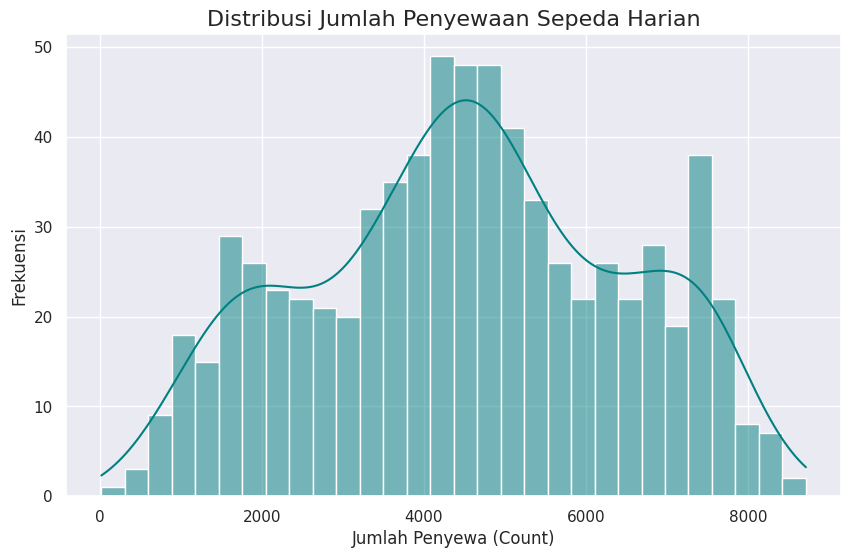

In [181]:
# Distribusi Target
plt.figure(figsize=(10, 6))
# Histogram dengan KDE (Kernel Density Estimate)
sns.histplot(day_df['count'], kde=True, bins=30, color='teal')
plt.title('Distribusi Jumlah Penyewaan Sepeda Harian', fontsize=16)
plt.xlabel('Jumlah Penyewa (Count)', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.show()

**Insight**
- Histogram menunjukkan distribusi jumlah penyewaan yang mendekati normal. Mayoritas penyewaan harian berkisar antara 4.000 hingga 5.000 unit, dengan rentang variasi dari minimum ~22 hingga maksimum ~8.700 unit. Tidak terlihat skewness (kemiringan) yang ekstrem, sehingga data target ini aman digunakan untuk pemodelan Machine Learning tanpa perlu transformasi logaritma.

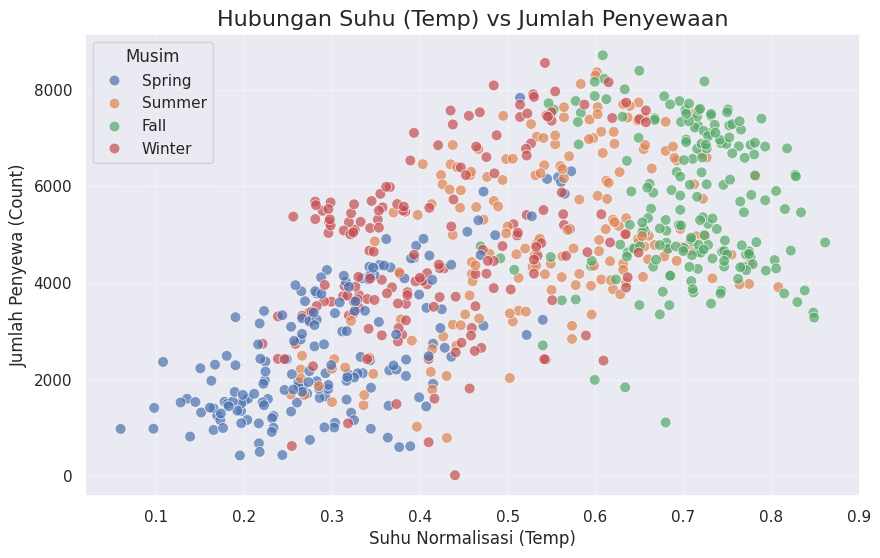

In [182]:
# Hubungan Numerik
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='temp',
    y='count',
    data=day_df,
    hue='season_label',
    palette='deep',
    s=60,
    alpha=0.7
)
plt.title('Hubungan Suhu (Temp) vs Jumlah Penyewaan', fontsize=16)
plt.xlabel('Suhu Normalisasi (Temp)', fontsize=12)
plt.ylabel('Jumlah Penyewa (Count)', fontsize=12)
plt.legend(title='Musim', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Insight**
- Berdasarkan scatterplot, terdapat pengelompokan yang jelas di mana musim Semi berada di kuadran rendah (dingin & sepi), sedangkan musim Gugur dan Panas mendominasi kuadran tinggi (hangat & ramai). Pola linear yang terbentuk mengonfirmasi bahwa setiap kenaikan suhu memiliki kontribusi langsung terhadap peningkatan jumlah penyewaan.

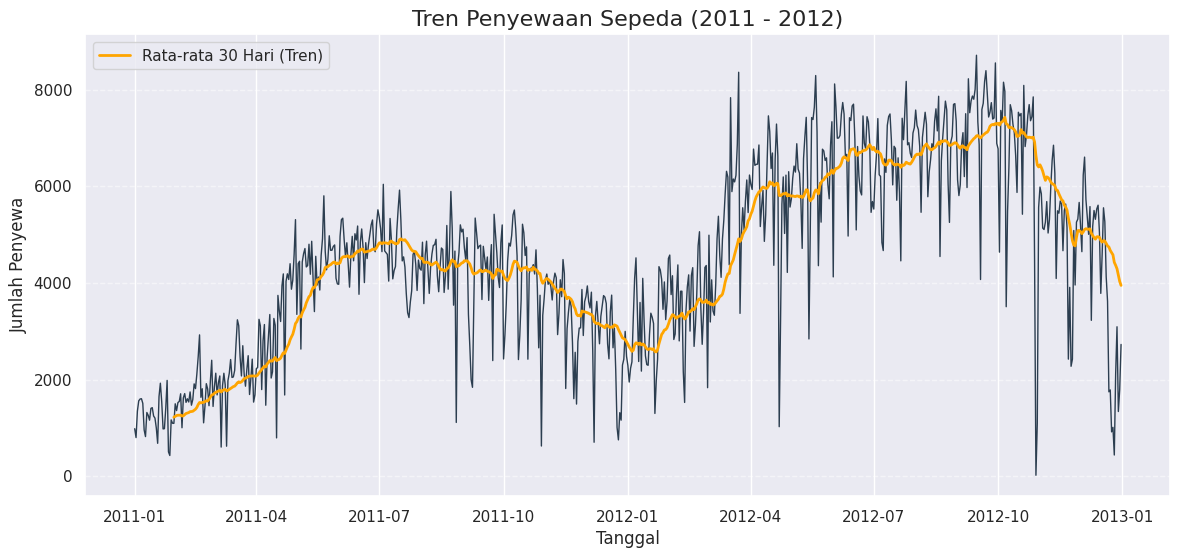

In [183]:
# Tren Waktu
plt.figure(figsize=(14, 6))
# Line plot berdasarkan tanggal (dteday)
sns.lineplot(x='dteday', y='count', data=day_df, color='#2c3e50', linewidth=1)
# Menambahkan (rata-rata bergerak) per 30 hari agar tren lebih terlihat
day_df['rolling_mean'] = day_df['count'].rolling(window=30).mean()
sns.lineplot(x='dteday', y='rolling_mean', data=day_df, color='orange', linewidth=2, label='Rata-rata 30 Hari (Tren)')
plt.title('Tren Penyewaan Sepeda (2011 - 2012)', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Jumlah Penyewa', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**Insight**
- Grafik tren waktu menunjukkan bahwa bisnis bike sharing memiliki pola musiman (cyclical) yang kuat, dengan puncak permintaan selalu terjadi di pertengahan tahun. Selain itu, terdapat tren pertumbuhan positif secara keseluruhan (uptrend), di mana volume penyewaan pada tahun 2012 secara konsisten lebih tinggi dibandingkan tahun 2011, menandakan perluasan pasar sukses.

/tmp/ipython-input-4112816046.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_agg.index, y=monthly_agg.values, palette='viridis')


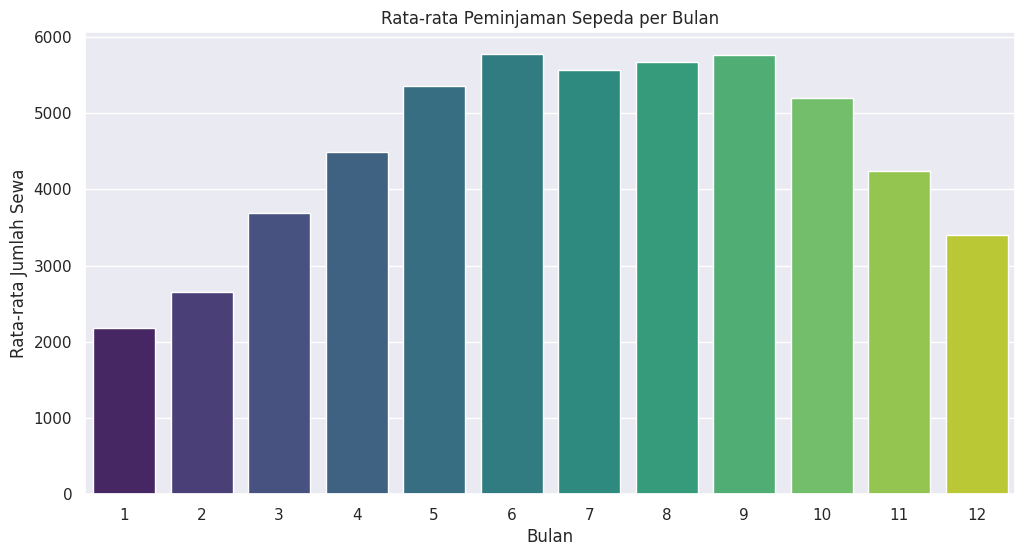

In [184]:
# Tren Bulanan
plt.figure(figsize=(12, 6))
monthly_agg = day_df.groupby('month')['count'].mean()
sns.barplot(x=monthly_agg.index, y=monthly_agg.values, palette='viridis')
plt.title('Rata-rata Peminjaman Sepeda per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Rata-rata Jumlah Sewa')
plt.show()

**Insight:**
- Barplot bulanan menunjukkan pola distribusi normal yang jelas, dengan permintaan rendah di musim dingin (Q1 & Q4) dan memuncak secara signifikan pada musim panas dan gugur (Q2 & Q3). Bulan Juni hingga September adalah periode krusial yang menyumbang mayoritas pendapatan tahunan.


## Visualization & Explanatory Analysis
Visualisasi data membantu manusia memahami data dengan lebih cepat dan jelas. Fungsi utama visualisasi data adalah membuat data yang kompleks menjadi lebih mudah dibaca dan dipahami, membantu menemukan pola, tren, serta data yang tidak normal dengan cepat, serta menyampaikan hasil analisis kepada orang non-teknis secara jelas dan efektif.


### Pertanyaan 1:
Bagaimana pengaruh kondisi cuaca terhadap jumlah rata-rata penyewaan sepeda harian?

/tmp/ipython-input-2285734338.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


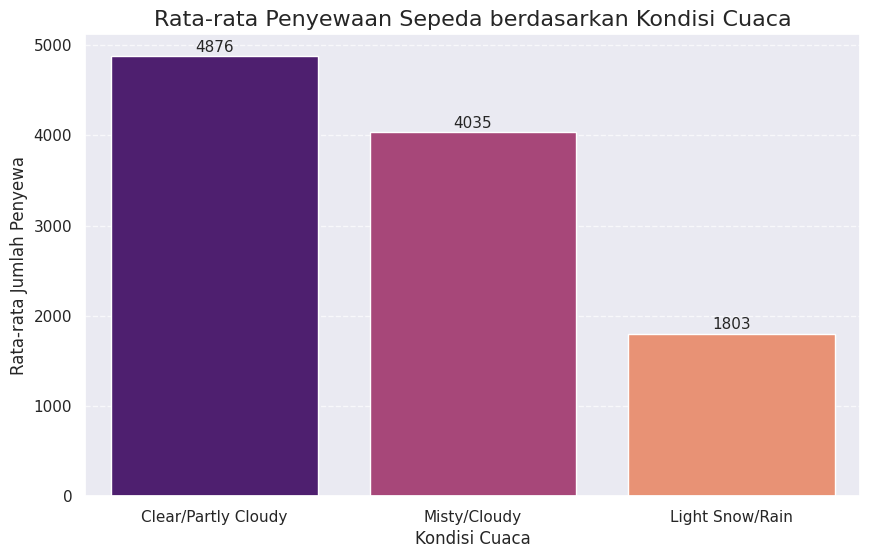

In [185]:
plt.figure(figsize=(10, 6))

# Menghitung urutan berdasarkan rata-rata jumlah sewa supaya grafik urut dari tinggi ke rendah
order_weather = day_df.groupby('weather_label')['count'].mean().sort_values(ascending=False).index
# Membuat Barplot
sns.barplot(
    x='weather_label',
    y='count',
    data=day_df,
    order=order_weather, # Mengurutkan bar
    palette='magma',
    errorbar=None # Menghilangkan garis error bar agar lebih bersih
)
plt.title('Rata-rata Penyewaan Sepeda berdasarkan Kondisi Cuaca', fontsize=16)
plt.xlabel('Kondisi Cuaca', fontsize=12)
plt.ylabel('Rata-rata Jumlah Penyewa', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Grid horizontal tipis
# Menambahkan label angka di atas bar
for i, v in enumerate(day_df.groupby('weather_label')['count'].mean().sort_values(ascending=False)):
    plt.text(i, v + 50, f"{int(v)}", ha='center', fontsize=11)
plt.show()

**Insight**
- Clear / Partly Cloudy (Cerah)
Pada cuaca cerah, penyewaan sepeda paling tinggi. Kondisi ini menjadi sumber pendapatan utama karena orang merasa nyaman untuk bersepeda.

- Misty / Cloudy (Mendung)
Saat cuaca mendung, jumlah penyewaan sedikit menurun tetapi masih tergolong stabil. Bisnis tetap berjalan dengan baik meskipun tidak seramai saat cuaca cerah.

- Light Snow / Rain (Hujan atau Salju Ringan)
Pada kondisi ini, penyewaan turun drastis lebih dari setengah. Cuaca buruk membuat minat bersepeda sangat rendah dan pendapatan ikut menurun tajam.

Hal ini menunjukkan bahwa cuaca adalah risiko terbesar dari luar yang tidak bisa dikendalikan oleh manajemen, tetapi harus diperhitungkan sejak awal saat membuat perkiraan pendapatan.

### Pertanyaan 2:

Apakah ada perbedaan pola penyewaan antara hari kerja (workingday) dan hari libur (holiday)?





/tmp/ipython-input-1367284727.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


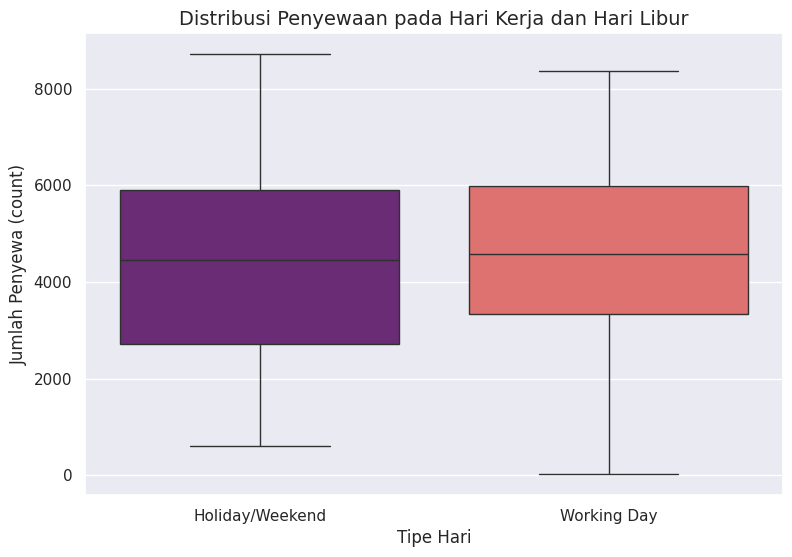

In [186]:
plt.figure(figsize=(9, 6))
# Membuat Boxplot untuk melihat distribusi dan outlier
sns.boxplot(
    x='workingday_label',
    y='count',
    data=day_df,
    palette='magma'
)
plt.title('Distribusi Penyewaan pada Hari Kerja dan Hari Libur', fontsize=14)
plt.xlabel('Tipe Hari', fontsize=12)
plt.ylabel('Jumlah Penyewa (count)', fontsize=12)
plt.show()

**Insight:**
- Working Day sedikit lebih tinggi daripada Holiday/Weekend. Hal ini enunjukkan bahwa fungsi utama sepeda cenderung sebagai alat transportasi harian (pergi-pulang kantor/sekolah). Pengguna langganannya adalah pekerja yang membutuhkan transportasi murah dan cepat di hari kerja.
- Meskipun lebih rendah, Holiday tingginya tidak jauh beda (hanya selisih ~250 unit). Bisnis ini tidak mati di akhir pekan. Justru menunjukkan bahwa di hari libur, fungsi sepeda berubah dari "transportasi" menjadi "rekreasi/olahraga".
- Kotak untuk Working Day lebih pendek/ramping dibanding Holiday yang lebih panjang/lebar. Artinya, permintaan di hari kerja lebih stabil dan dapat diprediksi (orang pasti berangkat kerja). Sedangkan di hari libur, permintaannya lebih fluktuatif (kadang sangat ramai kalau ada event, kadang sepi kalau orang malas keluar).

Hal ini menunjukkan bahwa sepeda paling banyak digunakan untuk kebutuhan komuter (bekerja/sekolah). Namun, tingginya angka penyewaan di hari libur membuktikan bahwa layanan ini juga populer untuk tujuan rekreasi. Strategi bisnis harus menyeimbangkan ketersediaan armada dan fokus pada rute perkantoran saat hari kerja serta rute wisata/taman saat akhir pekan.

### Pertanyaan 3:
Bagaimana perbedaan pola penyewaan sepeda berdasarkan musim dan jenis hari (hari kerja vs hari libur)?

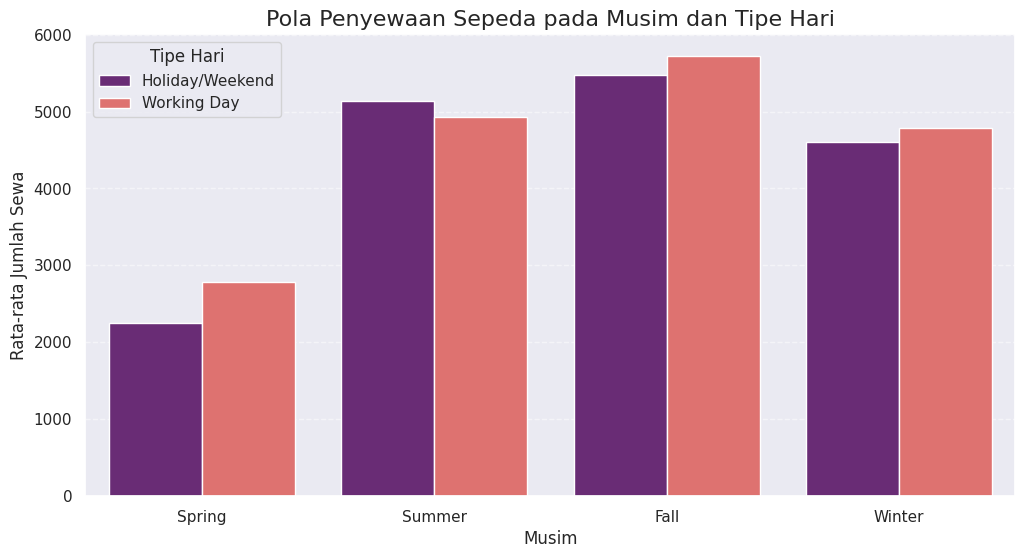

In [187]:
plt.figure(figsize=(12, 6))

# Mengatur urutan musim agar logis (bukan alfabetis)
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Membuat Clustered Bar Plot
sns.barplot(
    x='season_label',
    y='count',
    hue='workingday_label',  # Memisahkan batang menjadi dua warna
    data=day_df,
    palette='magma',
    order=season_order,      # Memastikan urutan musim benar
    errorbar=None            # Menghilangkan garis error bar
)

plt.title('Pola Penyewaan Sepeda pada Musim dan Tipe Hari', fontsize=16)
plt.xlabel('Musim', fontsize=12)
plt.ylabel('Rata-rata Jumlah Sewa', fontsize=12)
plt.legend(title='Tipe Hari', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

**Insight**
- Musim Panas (The Summer Flip). Biasanya, penyewaan di Hari Kerja (Working Day) lebih tinggi daripada Hari Libur. Pada Summer ini polanya terbalik, rata-rata penyewaan di Hari Libur (5.142) justru mengalahkan Hari Kerja (4.926). Menunjukkkan bahwa di musim panas, perilaku konsumen berubah. Sepeda tidak lagi sekadar alat transportasi ke kantor, tapi menjadi alat rekreasi/wisata. Orang-orang lebih suka bersepeda santai di taman atau tempat wisata saat liburan musim panas.
- Musim Gugur (Fall). Baik itu hari kerja maupun hari libur, batang grafik untuk kategori Fall selalu menjadi yang paling tinggi dibandingkan musim lainnya. Cuaca di musim gugur (sejuk, tidak terlalu panas seperti Summer dan tidak dingin seperti Winter) adalah kondisi paling ideal yang menciptakan keseimbangan sempurna di mana kaum pekerja (komuter) dan kaum rekreasi sama-sama aktif menyewa sepeda.
- Konsistensi Pekerja. Kecuali di musim panas, batang untuk Hari Kerja (Working Day) selalu lebih tinggi daripada Hari Libur di musim Semi, Gugur, dan Dingin yang membuktikan bahwa basis pengguna utama sistem bike sharing adalah penduduk lokal yang bekerja/sekolah. Mereka adalah pelanggan setia yang menggunakan sepeda sebagai transportasi utilitas sepanjang tahun, kecuali saat liburan musim panas tiba.

Hal ini menujukkan bahwa musim panas adalah musim rekreasi (didominasi penggunaan hari libur), sedangkan musim lainnya adalah musim komuter (didominasi penggunaan hari kerja). Musim Gugur menjadi periode puncak dengan volume tertinggi di kedua kategori hari, menandakan kondisi cuaca yang paling kondusif untuk semua jenis pengguna.

## Analisis Lanjutan (Random Forest Regresi)

Alasan menggunakan Random Forest Regressor karena tujuan analisis adalah memprediksi jumlah penyewaan sepeda dalam bentuk angka (regresi), bukan mengelompokkan data ke dalam kategori. Model random forest sangat cocok karena mampu menangkap hubungan yang kompleks dan tidak selalu linear antara berbagai faktor seperti cuaca, suhu, musim, dan jenis hari terhadap jumlah penyewaan. Selain itu, Random Forest bersifat lebih stabil karena terdiri dari banyak pohon keputusan, sehingga tidak mudah terpengaruh oleh data ekstrem atau outlier. Keunggulan lainnya, model ini juga dapat menunjukkan faktor-faktor yang paling berpengaruh melalui fitur feature importance, sehingga membantu memahami variabel apa saja yang paling menentukan tinggi rendahnya jumlah penyewaan sepeda dan mendukung pengambilan keputusan bisnis yang lebih tepat.

In [188]:
# --- FEATURE SELECTION ---
# Kolom yang harus DIHAPUS:
# 'instant': Hanya indeks, tidak punya makna prediktif.
# 'dteday': Tipe tanggal, model butuh angka (informasi waktu sudah ada di 'year', 'month', 'weekday').
# 'casual' & 'registered': WAJIB DIBUANG. Karena casual + registered = count (target).
#    Jika tidak dibuang, model akan bocor dan akurasinya 100% palsu.
# Kolom '_label' (season_label, dll): gunakan kolom angka aslinya saja.

drop_cols = ['instant', 'dteday', 'casual', 'registered', 'count',
             'season_label', 'weather_label', 'workingday_label', 'rolling_mean']

# Menghapus kolom yang benar-benar ada di dataframe
existing_drop = [c for c in drop_cols if c in day_df.columns]

X = day_df.drop(columns=existing_drop) # Features (X)
y = day_df['count']                    # Target (y)

# Cek tipe data X (harus semua angka)
print("Fitur yang digunakan:", X.columns.tolist())

Fitur yang digunakan: ['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'humidity', 'windspeed']


In [189]:
# Split Data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi Model Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Latih Model
rf_model.fit(X_train, y_train)

# Prediksi pada data test
y_pred = rf_model.predict(X_test)

# Evaluasi Sederhana
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

RMSE: 677.09
R2 Score: 0.89


/tmp/ipython-input-1457396392.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


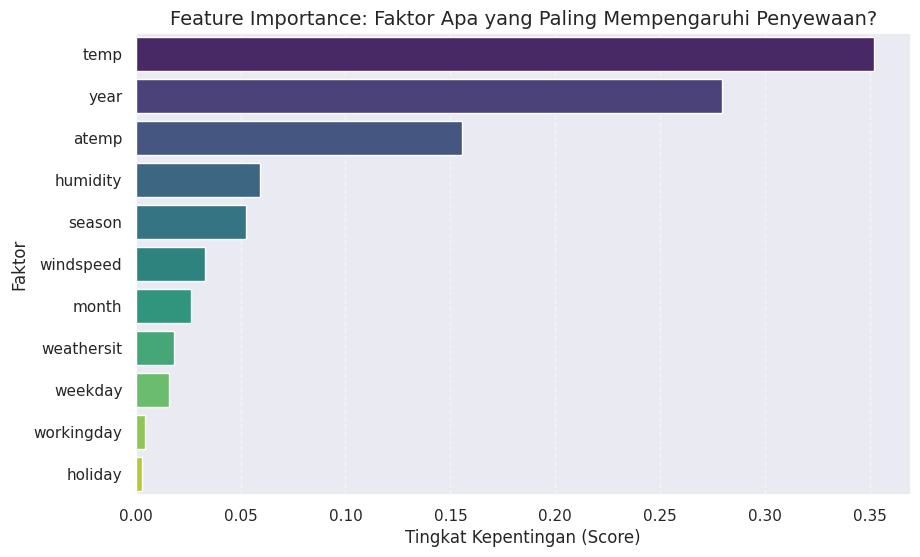

In [190]:
# Mengambil skor feature importance
importances = rf_model.feature_importances_
feature_names = X.columns

# Membuat DataFrame untuk visualisasi
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance: Faktor Apa yang Paling Mempengaruhi Penyewaan?', fontsize=14)
plt.xlabel('Tingkat Kepentingan (Score)', fontsize=12)
plt.ylabel('Faktor', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

**Insight**
- Suhu adalah faktor paling penting. Jika cuaca hangat, penyewaan pasti naik. Jika dingin, orang cenderung malas bersepeda. Karena itu, saat ramalan cuaca hangat, semua sepeda harus siap digunakan.
- Bisnis terus tumbuh dari tahun ke tahun. Faktor tahun menunjukkan adanya peningkatan penyewaan dari tahun sebelumnya. Berarti jumlah pengguna makin banyak dan bisnis berkembang seiring waktu.
- Hujan dan kelembaban lebih berpengaruh daripada angin. Pelanggan masih mau bersepeda saat berangin, tapi enggan saat hujan atau udara sangat lembab. Jadi, hujan lebih menurunkan penyewaan dibanding angin.
- Perbedaan hari kerja dan hari libur tidak terlalu besar. Sepeda tetap banyak disewa setiap hari, hanya tujuan penggunaannya yang berbeda (kerja vs rekreasi).

Analisis Feature Importance menegaskan bahwa faktor lingkungan (terutama Suhu) adalah penggerak utama permintaan jangka pendek, sedangkan faktor waktu (Tahun) menunjukkan tren pertumbuhan bisnis jangka panjang. Jenis hari (kerja vs libur) memiliki pengaruh minim terhadap total volume penyewaan, menandakan memiliki product-market fit yang kuat di berbagai segmen pengguna (baik pekerja maupun wisatawan).

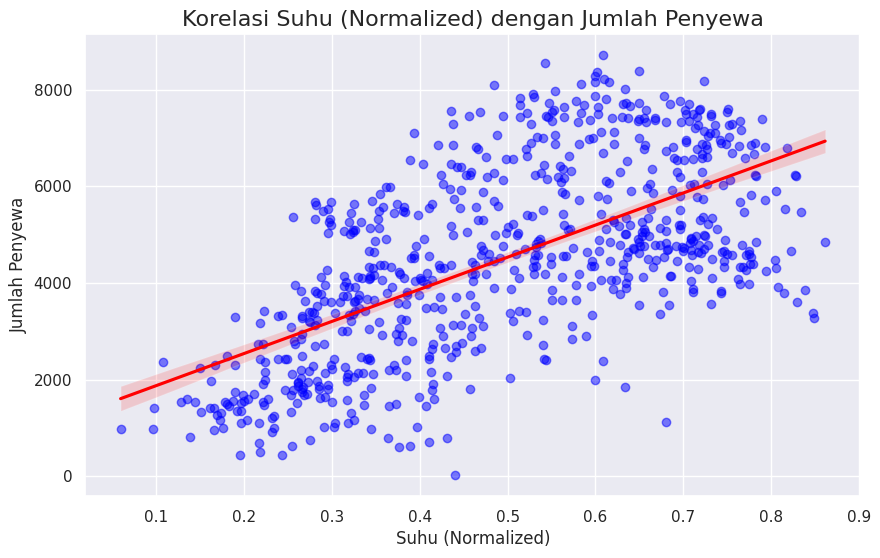

In [191]:
plt.figure(figsize=(10, 6))

# Scatter plot dengan garis regresi
sns.regplot(
    x='temp',
    y='count',
    data=day_df,
    scatter_kws={'alpha': 0.5, 'color': 'blue'}, # Transparansi titik
    line_kws={'color': 'red'}
)
plt.title('Korelasi Suhu (Normalized) dengan Jumlah Penyewa', fontsize=16)
plt.xlabel('Suhu (Normalized)', fontsize=12)
plt.ylabel('Jumlah Penyewa', fontsize=12)
plt.show()

**Insight**
- Garis merah yang menanjak mengonfirmasi bahwa semakin tinggi suhu, semakin banyak penyewaan sepeda yang terjadi. Saat cuaca hangat, orang lebih tertarik menyewa sepeda, dan saat dingin jumlah sewa menurun.
- Kenyamanan sangat menentukan keputusan pengguna, karena bersepeda dilakukan di luar ruangan, orang cenderung menghindari cuaca dingin. Mereka lebih nyaman dan mau bersepeda saat suhu terasa hangat.
- Model regresi ini dapat membantu bisnis memperkirakan lonjakan permintaan. Jika ramalan cuaca besok menunjukkan suhu tinggi, penyedia layanan harus menyiapkan lebih banyak unit sepeda di stasiun dan juga stok sepeda serta promosi perlu ditingkatkan karena peluang penyewaan paling besar.

## Conclusion

- Kesimpulan dari pertanyaan 1 berdasarkan hasil analisis pengaruh cuaca terhadap jumlah penyewaan sepeda, dapat disimpulkan bahwa kondisi cuaca memiliki dampak yang sangat signifikan terhadap minat penyewa. Rata-rata penyewaan tertinggi terjadi pada saat cuaca Cerah/Berawan (Clear/Partly Cloudy), yang menunjukkan bahwa pengguna sangat menyukai kondisi kondusif untuk bersepeda. Sebaliknya, terjadi penurunan drastis pada jumlah penyewaan saat cuaca memburuk menjadi Hujan Ringan/Salju. Hal ini mengindikasikan bahwa bisnis ini sangat bergantung pada faktor eksternal (cuaca), sehingga manajemen stok harus disesuaikan dengan ramalan cuaca harian.

- Kesimpulan dari pertanyaan 2 berdasarkan analisis perbandingan antara hari kerja dan hari libur, disimpulkan bahwa pola penggunaan sepeda didominasi oleh aktivitas rutin (komuter). Jumlah penyewaan pada Hari Kerja (Working Day) cenderung lebih tinggi dan memiliki variasi yang lebih stabil dibandingkan hari libur. Ini menunjukkan bahwa sepeda banyak digunakan sebagai sarana transportasi utama untuk pergi bekerja atau sekolah. Sementara itu, pada hari libur, penggunaan sepeda lebih bersifat naik-turun, mengindikasikan penggunaan untuk tujuan rekreasi atau olahraga yang tidak pasti.

- Kesimpulan dari pertanyaan 3 berdasarkan analisis interaksi antara musim dan tipe hari, ditemukan adanya pergeseran perilaku pengguna yang unik (The Summer Flip). Secara umum, Musim Gugur (Fall) adalah periode emas dengan performa terbaik di semua kategori hari. Namun, khusus pada Musim Panas (Summer), terjadi anomali di mana penyewaan pada Hari Libur justru lebih tinggi dibandingkan Hari Kerja. Hal ini menyimpulkan bahwa pada musim panas, fungsi utama layanan bergeser dari "transportasi" menjadi "wisata/rekreasi", sedangkan di musim lainnya sepeda tetap konsisten sebagai alat transportasi harian kaum pekerja.

**Insight Utama**

Hasil analisis menunjukkan bahwa suhu adalah faktor utama penentu pendapatan, di mana cuaca hangat mendorong peningkatan penyewaan sepeda, sementara hujan dapat menurunkan pendapatan secara drastis. Secara umum, sepeda lebih banyak digunakan pada hari kerja, menandakan bahwa pengguna utamanya adalah komuter yang memakainya untuk keperluan kerja atau sekolah. Musim gugur menjadi periode terbaik karena cuacanya paling nyaman dan menghasilkan penyewaan tertinggi, sementara musim panas memiliki pola unik karena penyewaan justru lebih ramai di hari libur akibat penggunaan untuk rekreasi. Selain itu, tren tahunan yang terus meningkat menunjukkan bahwa bisnis bike sharing ini sedang tumbuh dan semakin populer dari waktu ke waktu.